In [1]:
import torch
import torch.nn as nn
import torch.functional as f
import torch.optim as optim
import pandas as pd
from torch.utils.data import random_split, TensorDataset, DataLoader
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import time
import numpy as np

In [3]:
#Read and split dataset
bucket = 'sagemaker-ann-fyp'
data_key = 'complete_dataset.csv' 
travel_data = 's3://{}/{}'.format(bucket,data_key)

full_dataset = pd.read_csv(travel_data)

dataset_features = ['hod','sourcelong','sourcelat','dstlong','dstlat','distance']
X = full_dataset[dataset_features]
y = full_dataset['mean_travel_time']

train_X, test_X, train_y, test_y = train_test_split(X,y,random_state=0)

scaler = StandardScaler()

train_X_scaled = pd.DataFrame(scaler.fit_transform(train_X), columns = train_X.columns, index = train_X.index)
test_X_scaled = pd.DataFrame(scaler.transform(test_X), columns = test_X.columns, index = test_X.index)

display(train_X_scaled.head())

,hod,sourcelong,sourcelat,dstlong,dstlat,distance
90320,0.036806,-1.190965,0.163744,-0.988400,1.716541,0.648271
83028,0.457357,0.333569,-2.436622,0.180096,-1.756452,-0.520837
11867,0.877907,0.664416,-1.118368,-0.022824,-1.621043,-0.648328
62691,0.737724,1.756825,-1.033331,1.056976,-2.095188,-0.195192
105034,0.457357,0.478419,1.181438,0.285093,0.107508,-0.378492


In [8]:
pca = PCA(n_components = None)

train_X_reduced = pd.DataFrame(pca.fit_transform(train_X_scaled), index = train_X_scaled.index)
test_X_reduced = pd.DataFrame(pca.transform(test_X_scaled), index = test_X_scaled.index)

display(train_X_reduced.head())
display(test_X_reduced.head())

,0,1,2,3,4,5
90320,-2.021198,-0.665633,0.151666,0.283261,-0.357851,1.015216
83028,2.799813,-1.163442,0.457039,-0.075395,-0.155893,0.463657
11867,2.015665,-0.605590,0.656430,-0.630789,0.459530,-0.204796
62691,2.902472,0.608853,0.809908,-0.048219,0.661587,-0.593746
105034,-0.425712,0.890031,0.185729,-0.711251,0.331717,-0.667946


,0,1,2,3,4,5
79481,1.045308,-0.665287,-0.418263,1.051124,0.321068,1.082427
146145,-0.964215,-0.498421,1.814077,0.496389,-0.396297,1.056667
40592,1.227338,-0.334246,-0.933212,0.260315,0.387803,-0.828079
73084,-0.705346,-1.794293,-0.927249,1.310492,-0.668066,-0.623207
35092,0.735108,0.949831,-0.743403,-0.391301,0.393696,-0.172679


In [9]:
train_X_reduced = torch.FloatTensor(train_X_reduced.values)
test_X_reduced = torch.FloatTensor(test_X_reduced.values)

train_y = torch.FloatTensor(train_y.values)
test_y = torch.FloatTensor(test_y.values)

print(train_X_reduced)

tensor([[-2.0212, -0.6656,  0.1517,  0.2833, -0.3579,  1.0152],
        [ 2.7998, -1.1634,  0.4570, -0.0754, -0.1559,  0.4637],
        [ 2.0157, -0.6056,  0.6564, -0.6308,  0.4595, -0.2048],
        ...,
        [-0.6850, -0.9409,  0.0571, -0.2627, -0.5556, -0.0088],
        [ 1.5405, -2.1940, -0.9850, -0.4123,  0.1528, -0.1472],
        [ 2.3565, -1.5193, -1.6366,  0.4402, -0.2102,  0.3595]])


In [10]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [12]:
train_data = TensorDataset(train_X_reduced,train_y)
test_data = TensorDataset(test_X_reduced,test_y)

batch_size = 200

train_loader = DataLoader(train_data, shuffle=True, batch_size=batch_size)
test_loader = DataLoader(test_data, shuffle=False, batch_size=batch_size)

In [13]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim=1):
        super(MLP, self).__init__()
        
        assert out_dim==1, 'out_dim must be 1'
        
        self.in_dim = in_dim
        self.hidden_dim = hidden_dim
        self.out_dim = out_dim
        
         #creating a module list of hidden layers & adding the input layer as 1st layer in the list
        self.hidden_layers = nn.ModuleList([nn.Linear(self.in_dim, self.hidden_dim[0])])
        
        #create a list of hidden layers by pairing hidden layer dims, and a for loop to create layers 
        #depending on given list of dimensions
        hidden_layer_sizes = zip(self.hidden_dim[:-1], self.hidden_dim[1:])
        for (layer_in, layer_out) in hidden_layer_sizes:
            self.hidden_layers.extend([nn.Linear(layer_in, layer_out)])
        #creates the last layer    
        self.output = nn.Linear(self.hidden_dim[-1], self.out_dim)
        
        self.dropout = nn.Dropout(p = 0.5)
    
    def forward(self, x):
        #a for loop to loop through each layer in the hidden layer module list
        for h_layer in iter(self.hidden_layers):
            x = self.dropout(torch.relu(h_layer(x)))

        x = self.output(x)
        x = x.squeeze(1)
        return x

In [14]:
def mae_loss(y_pred, y_true):
    mae = torch.abs(y_true - y_pred).mean()
    return mae

In [15]:
mlp = MLP(train_X.shape[1], [14,10,6], 1).to(device)
print(mlp)
optimizer = optim.Adam(mlp.parameters(),lr=0.001)
criterion = nn.L1Loss()
#scheduler = optim.lr_scheduler.CyclicLR(optimizer, base_lr = 0.0001, max_lr = 0.003, step_size_up = 20, cycle_momentum = False)

MLP(
  (hidden_layers): ModuleList(
    (0): Linear(in_features=6, out_features=14, bias=True)
    (1): Linear(in_features=14, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=6, bias=True)
  )
  (output): Linear(in_features=6, out_features=1, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
)


In [ ]:
# Experiment 2
mlp = MLP(train_X.shape[1], [16,12,10,8,6,4], 1).to(device)
print(mlp)
criterion = nn.L1Loss()
optimizer = optim.Adagrad(mlp.parameters(),lr=0.0001, lr_decay = 0.9)

In [16]:
#early stopping
early_stopping = True
tol = 0.0001
patience = 10
#training phase
epochs = 1000
start_time = time.time()
#to plot loss curve after training
train_losses = []
valid_losses = []
early_stop_epochs = 0

for epoch in range(epochs):
    train_loss = 0
    epoch_start_time = time.time()
    mlp.train()
    num_batch = len(train_loader)
    
    for batch_id, (batch_x, batch_y) in enumerate(train_loader):
        optimizer.zero_grad()
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        
        y_pred = mlp(batch_x)

        loss = criterion(y_pred, batch_y)

        loss.backward()
        optimizer.step()

        elapsed_time = time.time() - epoch_start_time
        elapsed_min = int(elapsed_time / 60)
        elapsed_sec = elapsed_time - 60 * elapsed_min
        
        train_loss += loss.item()
        
        # cyclic learning rate
        #scheduler.step()

        print('\rEpoch:{} Batch:{}/{} Loss:{:.4f} Time:{}m{:.2f}s'.format(epoch + 1, batch_id+1, 
                                                                          num_batch, loss.item(),
                                                                          elapsed_min, elapsed_sec), end='')
    print()
    mlp.eval()
    valid_loss = 0
    best_loss = np.inf
    
    for batch_id, (batch_x, batch_y) in enumerate(test_loader):
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
    
        y_pred = mlp(batch_x)
        loss = criterion(y_pred, batch_y)
        valid_loss += loss.item()
    
    valid_loss /= len(test_loader)
    valid_losses.append(valid_loss)
    train_loss /= len(train_loader)
    train_losses.append(train_loss)
    
    #save model when validation loss is minimum
    if valid_loss < best_loss:
        best_loss = valid_loss
        torch.save(mlp.state_dict(), 'mlp_pytorch_test.model')
    
    print('Valid Loss:{:.4f}'.format(valid_loss))
    
    # Learning rate scheduler for plateaus
    #scheduler.step(valid_loss)
    
    #early stopping
    if early_stopping and epoch > 0:
        if np.abs(valid_losses[-1] - valid_losses[-2]) < tol:
            early_stop_epochs += 1
        else:
            early_stop_epochs = 0
        if early_stop_epochs == patience:
            print("Validation loss has not changed more than {} for {} epochs. Stopping...".format(tol, patience))
            break
    
runtime = time.time() - start_time

print("Total Runtime Elapsed: {:.0f} hours {:.0f} minutes {:.2f} seconds.".format(runtime//3600, runtime%3600//60, runtime%3600%60))

Epoch:1 Batch:562/562 Loss:1034.6433 Time:0m4.14s
Valid Loss:961.5638
Epoch:2 Batch:562/562 Loss:1048.5906 Time:0m2.59s
Valid Loss:664.7542
Epoch:3 Batch:562/562 Loss:959.3257 Time:0m3.59ss
Valid Loss:637.2838
Epoch:4 Batch:562/562 Loss:1037.1322 Time:0m3.36s
Valid Loss:599.1195
Epoch:5 Batch:562/562 Loss:998.6840 Time:0m3.09ss
Valid Loss:600.0017
Epoch:6 Batch:562/562 Loss:849.1636 Time:0m3.57ss
Valid Loss:594.6844
Epoch:7 Batch:562/562 Loss:903.6855 Time:0m3.54ss
Valid Loss:588.4672
Epoch:8 Batch:562/562 Loss:924.4380 Time:0m3.49ss
Valid Loss:605.4903
Epoch:9 Batch:562/562 Loss:874.1814 Time:0m2.83ss
Valid Loss:578.4463
Epoch:10 Batch:562/562 Loss:1011.4975 Time:0m3.28s
Valid Loss:599.6528
Epoch:11 Batch:562/562 Loss:864.8408 Time:0m2.22ss
Valid Loss:590.9661
Epoch:12 Batch:562/562 Loss:829.2884 Time:0m2.87ss
Valid Loss:541.0718
Epoch:13 Batch:562/562 Loss:850.9263 Time:0m3.06s
Valid Loss:544.1455
Epoch:14 Batch:562/562 Loss:886.0880 Time:0m3.28ss
Valid Loss:541.0594
Epoch:15 Batch:5

Epoch:117 Batch:562/562 Loss:704.1441 Time:0m3.06s
Valid Loss:517.5082
Epoch:118 Batch:562/562 Loss:770.1239 Time:0m3.00s
Valid Loss:521.3782
Epoch:119 Batch:562/562 Loss:784.3489 Time:0m1.88s
Valid Loss:527.5085
Epoch:120 Batch:562/562 Loss:749.2241 Time:0m2.84s
Valid Loss:523.9756
Epoch:121 Batch:562/562 Loss:794.5632 Time:0m3.02s
Valid Loss:522.9572
Epoch:122 Batch:562/562 Loss:752.9088 Time:0m1.84s
Valid Loss:526.7270
Epoch:123 Batch:562/562 Loss:830.8003 Time:0m2.42s
Valid Loss:526.3635
Epoch:124 Batch:562/562 Loss:801.7767 Time:0m2.81s
Valid Loss:520.0997
Epoch:125 Batch:562/562 Loss:812.1210 Time:0m3.49s
Valid Loss:523.3638
Epoch:126 Batch:562/562 Loss:755.5359 Time:0m2.18s
Valid Loss:523.2233
Epoch:127 Batch:562/562 Loss:804.6017 Time:0m1.95s
Valid Loss:520.8895
Epoch:128 Batch:562/562 Loss:756.9119 Time:0m3.48s
Valid Loss:519.9829
Epoch:129 Batch:562/562 Loss:698.5218 Time:0m3.46s
Valid Loss:522.4010
Epoch:130 Batch:562/562 Loss:715.8314 Time:0m2.67s
Valid Loss:518.6977
Epoch:

Epoch:232 Batch:562/562 Loss:738.4147 Time:0m2.11s
Valid Loss:520.0150
Epoch:233 Batch:562/562 Loss:856.9719 Time:0m3.13s
Valid Loss:521.4664
Epoch:234 Batch:562/562 Loss:747.9147 Time:0m2.36s
Valid Loss:524.3011
Epoch:235 Batch:562/562 Loss:758.6172 Time:0m3.79s
Valid Loss:522.0909
Epoch:236 Batch:562/562 Loss:742.0250 Time:0m3.62s
Valid Loss:517.3048
Epoch:237 Batch:562/562 Loss:675.8254 Time:0m2.70s
Valid Loss:518.2181
Epoch:238 Batch:562/562 Loss:753.5883 Time:0m2.00s
Valid Loss:524.0203
Epoch:239 Batch:562/562 Loss:741.4097 Time:0m1.85s
Valid Loss:518.8752
Epoch:240 Batch:562/562 Loss:811.8420 Time:0m3.07s
Valid Loss:519.6698
Epoch:241 Batch:562/562 Loss:740.4429 Time:0m2.36s
Valid Loss:514.6339
Epoch:242 Batch:562/562 Loss:741.6603 Time:0m2.08s
Valid Loss:511.5483
Epoch:243 Batch:562/562 Loss:789.0538 Time:0m1.98s
Valid Loss:517.3184
Epoch:244 Batch:562/562 Loss:674.9229 Time:0m2.44s
Valid Loss:511.9254
Epoch:245 Batch:562/562 Loss:689.0046 Time:0m1.99s
Valid Loss:518.0589
Epoch:

KeyboardInterrupt: 

Minimum Validation Loss is 509.9608
Best iteration: 231


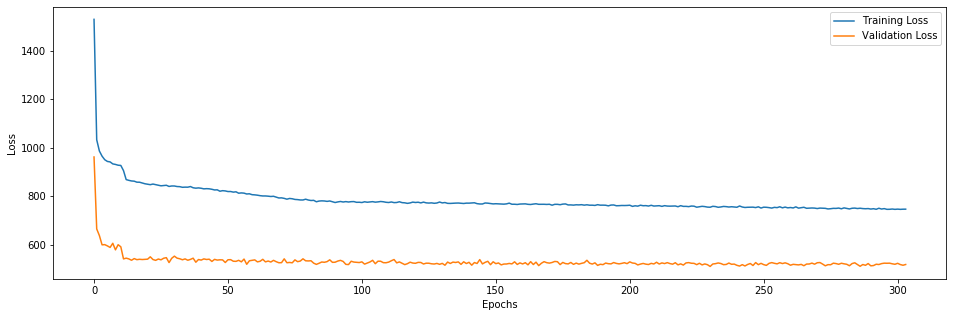

In [17]:
#plot validation loss curve, this may help to notice overfitting
plt.figure(figsize=(16,5))
plt.plot(train_losses, label = "Training Loss")
plt.plot(valid_losses, label = "Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(loc = 0)
print('Minimum Validation Loss is {:.4f}'.format(min(valid_losses)))
print("Best iteration: {}".format(np.argmin(valid_losses) + 1))

In [ ]:
x_test = np.array([[6,0.031180191,51.51122955,-0.044059634,51.54066292,9681]])
input_test = torch.tensor(x_test, dtype=torch.float, device=device )

mlp.load_state_dict(torch.load('mlp_pytorch_test.model'))
y_pred = mlp(input_test)
y_pred = y_pred.data.cpu().numpy()
print(y_pred)